In [1]:
from collections import *
from numpy import *
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sklearn.cluster
import sklearn.decomposition
import sklearn.feature_extraction.text
from sklearn.decomposition import PCA

from nltk.stem.snowball import SnowballStemmer
import nltk
import song_parsing

In [5]:
N_CLUSTERS = 3

desired_pos = ['IN', 'JJ', 'JJR', 'JJS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'RB', 'RBR', 'RBS', 'VB', 
    'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

def get_all_words_and_word_counts(songs):
    stemmer = SnowballStemmer("english")
    all_words = set([])
    song_counters = {}
    for song in songs:
        words = []
        for line in songs[song].split('\n'):
            t = nltk.word_tokenize(line.decode('utf-8'))
            tagged = nltk.pos_tag(t)
            for word in tagged:
                if word[1] in desired_pos:
                    words.append(word[0])
                                
        stemmed = []
        for word in words: 
            try:
                stem = stemmer.stem(word)
            except:
                stem = word
            stemmed.append(stem)
                            
        counter = Counter(stemmed)
        song_counters[song] = counter
        all_words = all_words.union( counter.iterkeys() )

    all_words = sorted(all_words)
    return all_words, song_counters
    
def get_all_representations_as_matrix(songs, song_counters, all_words):
    all_song_representations = [[] for i in range(len(songs))]
    for word in all_words:
        for song_index, song in enumerate(songs):
            all_song_representations[song_index].append(song_counters[song[0]][word] * 1.0) 
    return all_song_representations
    
def get_clusters(songs):
    all_words, song_counters = get_all_words_and_word_counts(songs)
    songs = list(songs.iteritems())

    all_song_representations = get_all_representations_as_matrix(songs, song_counters, all_words)
        
    #TF-IDF
    tfidf = sklearn.feature_extraction.text.TfidfTransformer(norm='l2',smooth_idf=True)
    communities = tfidf.fit_transform(all_song_representations).toarray()

    #SVD
    svd = sklearn.decomposition.TruncatedSVD(n_components=len(all_song_representations[0])/2)
    all_song_representations = svd.fit_transform(communities)
        
    clusterer = sklearn.cluster.KMeans(n_clusters=N_CLUSTERS, max_iter=500) #make max_iter higher later
    all_song_representations = np.array(all_song_representations) # as NP array
    cluster_labels = clusterer.fit_predict(all_song_representations)
    
    clusters = {}
    for song_index, cluster in enumerate(cluster_labels):
        if cluster not in clusters:
            clusters[cluster] = [songs[song_index][0]]
        else:
            clusters[cluster].append(songs[song_index][0])
    return all_song_representations, clusters, cluster_labels

In [6]:
songs = song_parsing.get_all_song_lyrics("Taylor Swift")

In [7]:
all_song_reps, clusters, cluster_labels = get_clusters(songs)

In [8]:
svd = sklearn.decomposition.TruncatedSVD(n_components=2)
t = svd.fit_transform(all_song_reps)

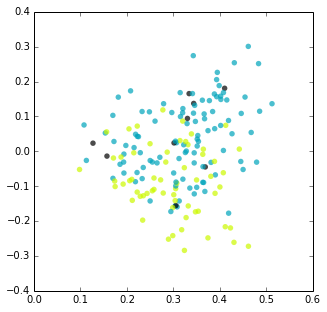

In [9]:
%matplotlib inline
plt.figure(figsize=(5,5))
colors = cm.spectral(cluster_labels.astype(float) / N_CLUSTERS)
plt.scatter(t[:, 0], t[:, 1], marker='.', s=120, lw=0, alpha=0.7, c=colors)
plt.show()

In [10]:
print Counter(cluster_labels)
for cluster in clusters:
    print clusters[cluster]

Counter({1: 103, 2: 61, 0: 9})
['Monologue Song (La La La)', 'Stay Beautiful', 'Better Off', 'Safe & Sound', 'Speak Now', 'Fifteen', 'Never Fade', 'Superman', 'I Almost Do']
['A Place In This World', 'Long Time Coming', 'By The Way', 'Stay Stay Stay', 'One Way Ticket', 'Breathe', 'Angelina', '22', 'Spinning Around', 'Writing Songs About You', 'Everything Has Changed', "I'd Lie", 'Nevermind', 'Welcome To New York', 'Can I Go With You', 'New Romantics', 'The Lucky One', 'The Way I Loved You', 'Last Kiss', "I'm Only Me When I'm With You", 'Am I Ready For Love', 'Lucky You', 'Long Live', 'Drops Of Jupiter', 'Enchanted', 'Jump Then Fall', 'Wait For Me', 'Santa Baby', 'Shake It Off', 'Christmas Must Be Something More', 'Riptide', 'This Here Guitar', 'Teardrops On My Guitar', 'Smokey Black Nights', 'Love Story', 'One Thing', 'Picture To Burn', 'Holy Ground', 'Cross My Heart', 'Blank Space', 'Better Than Revenge', 'Bad Blood', 'Girl At Home', 'Eyes Open', 'You Belong With Me', 'Dear John', 'I 